# 0. Setup

## 0.1 Imports

In [ ]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np

## 0.2 Helpers

In [ ]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

import matplotlib.style
import matplotlib as mpl
# mpl.style.use('classic')
mpl.rcParams['image.cmap'] = 'viridis'


def display_images(in_, out, label, n=1, count=False):
    title_set = False
    for N in range(n):
      if in_ is not None:
        in_pic = in_.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 4))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(in_pic[i+4*N])
            plt.axis('off')
      if out is not None:
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

def plot_samples_grid(ds_loader, n_rows=8, n_cols=8, fig_size=8, img_dim=28, title=None):
  
  f, axarr = plt.subplots(n_rows, n_cols, figsize=(fig_size, fig_size))

  images, labels = next(iter(ds_loader))

  for i, ax in enumerate(axarr.flat):
      ax.imshow(images[i].view(img_dim, img_dim))
      ax.axis('off')
      
  plt.suptitle(title)
  plt.show()

## 0.3 Globals

In [ ]:
# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

# 1. Prepare Dataset

## 1.1. Load MNIST

In [ ]:
# set batch size
batch_size = 256

In [ ]:
# transformation to apply to each data point (image)
transformer = lambda x: transforms.ToTensor()(x)

# define the train and test datasets
ds_train = MNIST("./data", train=True, transform=transformer, download=True)
ds_test = MNIST("./data", train=False, transform=transformer)

# data loaders to load data in batches from the datasets
train_loader = DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)
test_loader = DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)

##1.2 Plot Random Samples

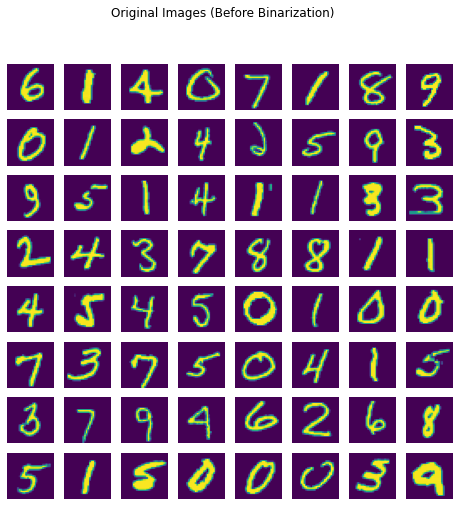

In [ ]:
plot_samples_grid(train_loader, title='Original Images (Before Binarization)')

##1.3 Transform to Binarized MNIST

In [ ]:
def binarizer(x):
  intensities = transforms.ToTensor()(x)
  t = torch.Tensor([0.5])
  out = (intensities >= t).float() * 1
  return out

# define the train and test datasets
bin_ds_train = MNIST("./bin_data", train=True, transform=binarizer, download=True)
bin_ds_test = MNIST("./bin_data", train=False, transform=binarizer)

# data loaders to load data in batches from the datasets
bin_train_loader = DataLoader(dataset=bin_ds_train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)
bin_test_loader = DataLoader(dataset=bin_ds_test, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)

##1.4 Plot Binarized MNIST Samples

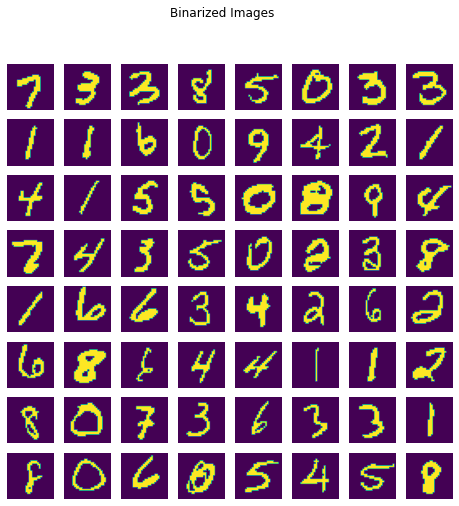

In [ ]:
plot_samples_grid(bin_train_loader, title='Binarized Images')

# 2. VAE

## 2.1. Setting up the model

### 2.1.1 Implement a VAE Module

In [ ]:
# hyper params
latent_size = 20

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, latent_size * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
      mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, latent_size)
      mu = mu_logvar[:, 0, :]
      logvar = mu_logvar[:, 1, :]
      return mu, logvar

    def decode(self, z):
      return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def sample(self, n_samples):
      z = torch.randn((n_samples, latent_size)).to(device)
      return self.decode(z)

model = VAE().to(device)

In [ ]:
# Setting the optimiser
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar):
    
    # reconstruction loss (pushing the points apart)
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )

    # KL divergence loss (the relative entropy between two distributions a multivariate gaussian and a normal)
    # (enforce a radius of 1 in each direction + pushing the means towards zero)
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD # we can use a beta parameter here (BCE + beta * KLD)

### 2.1.2. Generate samples from the untrained model

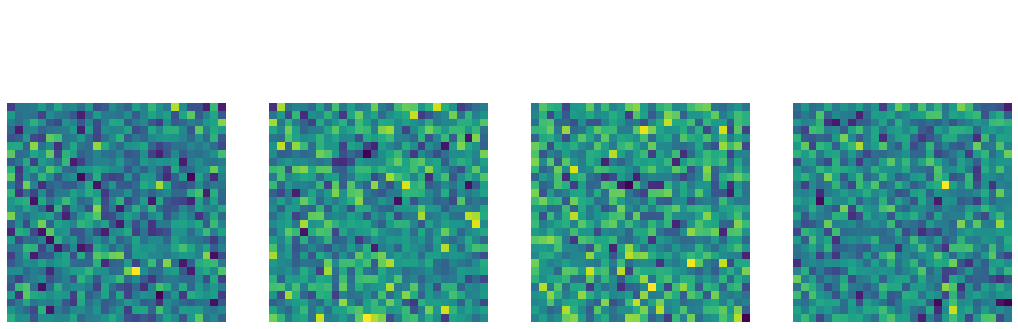

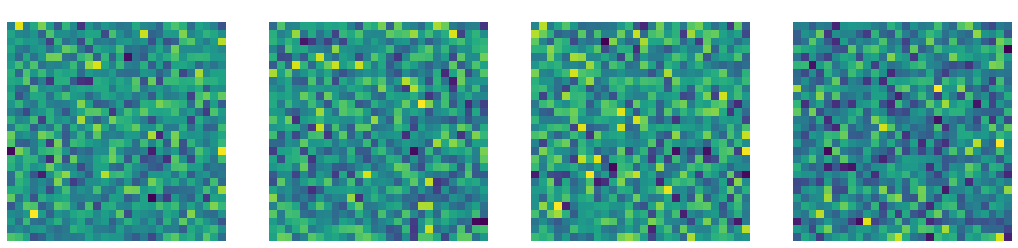

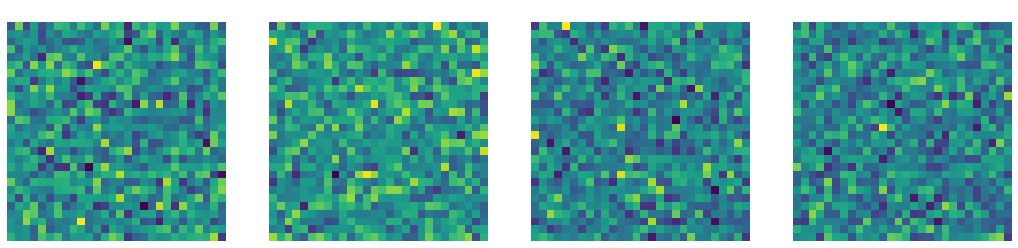

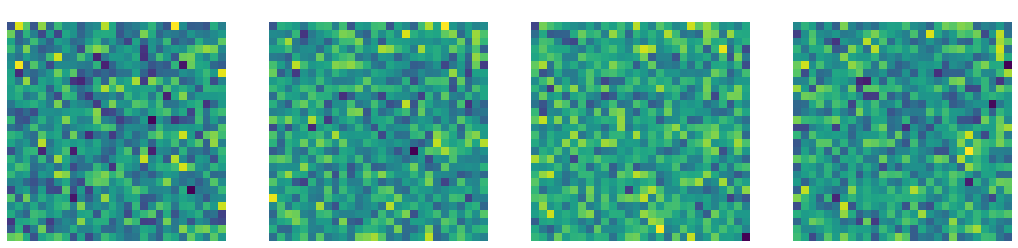

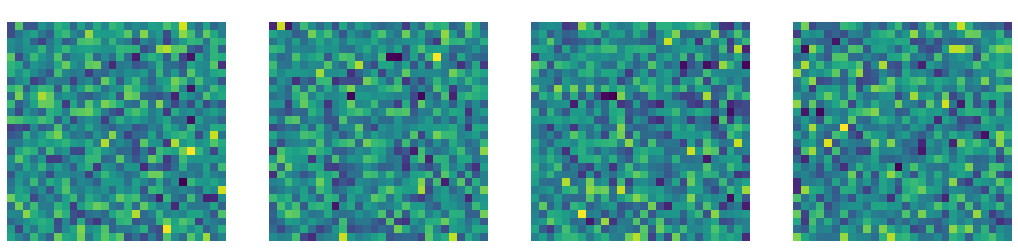

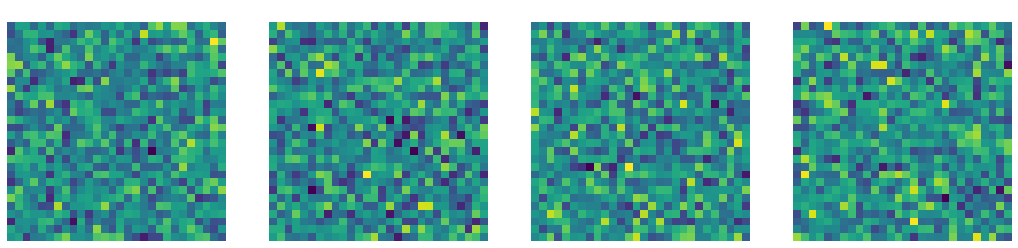

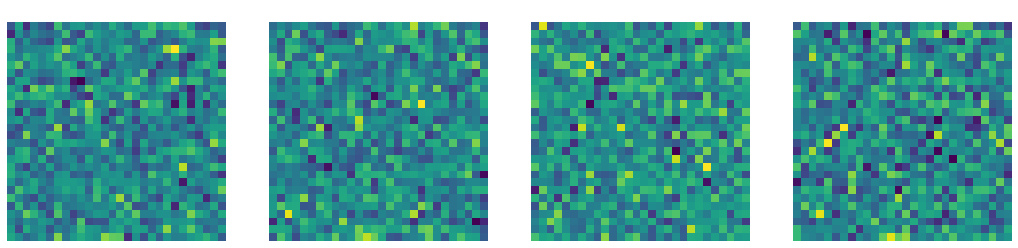

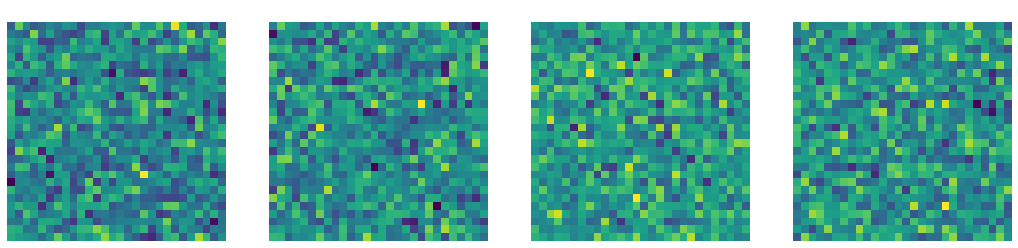

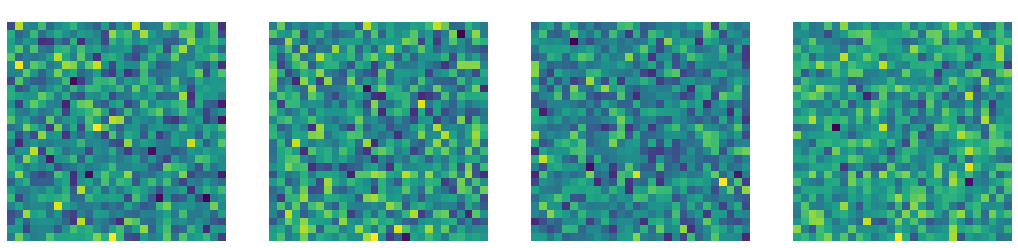

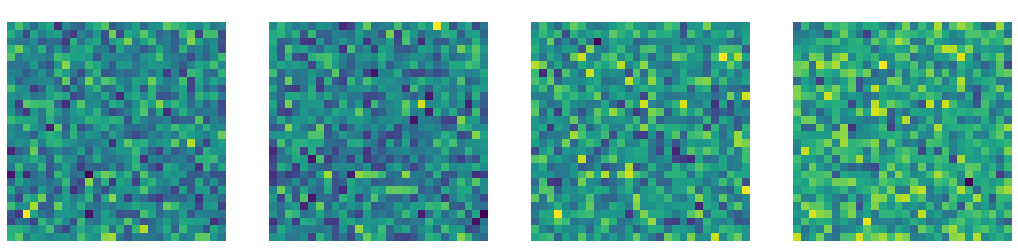

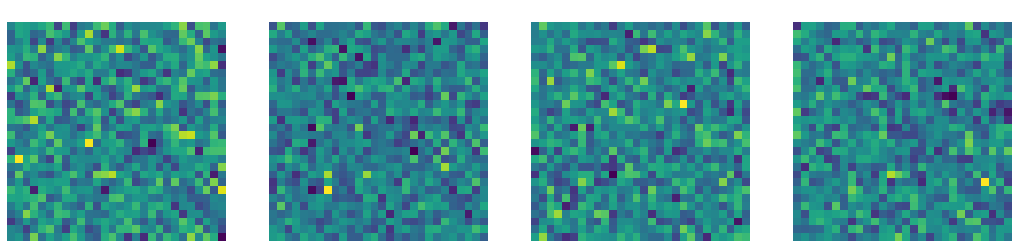

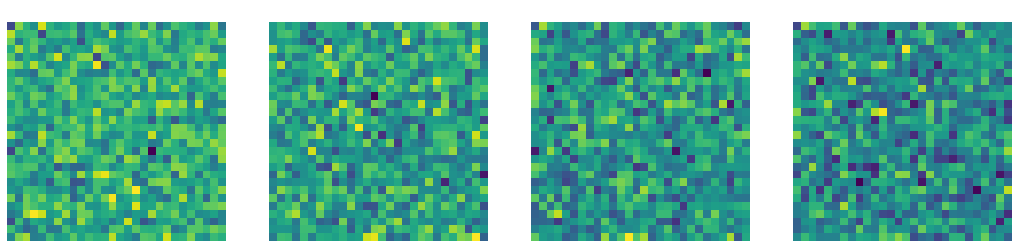

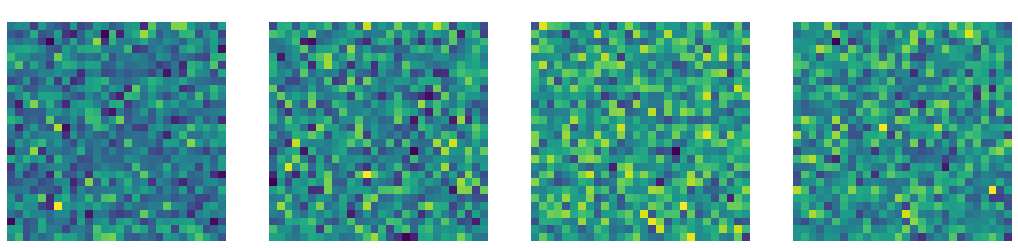

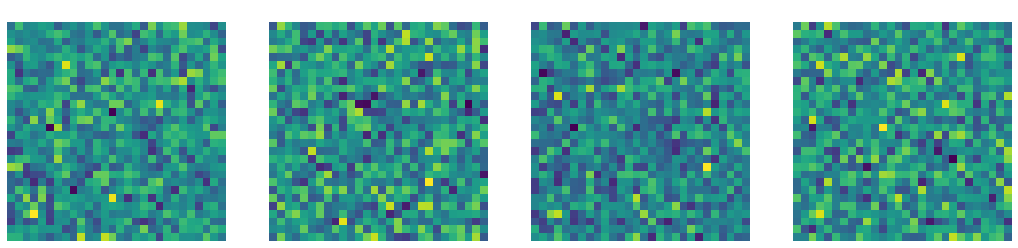

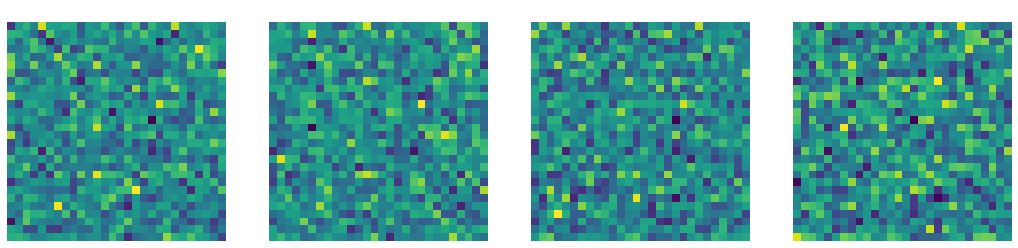

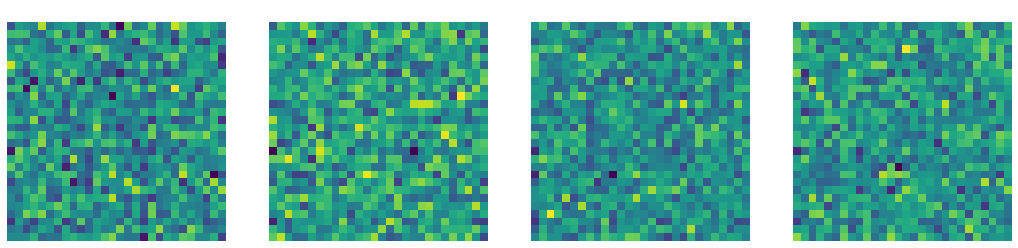

In [ ]:
# Generating 64 samples from the untrained model
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - Untrained Model', 64 // 4, count=True)

### 2.1.3. ELBO of samples from training set using the untrained model

In [ ]:
# Compute the ELBO of 64 samples from the training set using the untrained model
with torch.no_grad():
  model.eval()
  # load a batch (it will be of 256 samples)
  images, _ = next(iter(bin_train_loader))
  # we only want 64 samples
  only_64 = images[0:64, :, :, :]
  # send them to the appropriate device
  only_64 = only_64.to(device)
  # forward
  x_hat, mu, logvar = model(only_64)
  # TODO: there is a miss-match in the dims but the size is the same
  elbo_64_untrained = loss_function(x_hat, only_64, mu, logvar).item()

print(f'ELBO of 64 samples using the untrained model: {elbo_64_untrained:.4f}')

ELBO of 64 samples using the untrained model: 34865.0547


## 2.2. Setting up the training

### 2.2.1. Implement train and test functions

In [ ]:
# performs one epoch of training and returns the training loss for this epoch
def train():
  model.train()
  train_loss = 0
  for x, _ in bin_train_loader:
    x = x.to(device)
    # ===================forward=====================
    x_hat, mu, logvar = model(x)
    loss = loss_function(x_hat, x, mu, logvar)
    train_loss += loss.item()
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return train_loss

# evaluates the model on the test set
def test(epoch):
  means, logvars, labels, images = list(), list(), list(), list()
  test_loss = 0
  with torch.no_grad():
    model.eval()
    for x, y in bin_test_loader:
      x = x.to(device)
      # forward
      x_hat, mu, logvar = model(x)
      test_loss += loss_function(x_hat, x, mu, logvar).item()
      # log
      means.append(mu.detach())
      logvars.append(logvar.detach())
      labels.append(y.detach())
      images.append(x.detach())
  display_images(None, x_hat, f'Epoch {epoch} - Reconstructed Images', 1)
  return test_loss, means, logvars, labels, images

### 2.2.2. Train the model and Evaluate on the testset

In [ ]:
# Training the model
epochs = 50
codes = dict(μ=list(), logσ2=list(), y=list(), x=list())
for epoch in range(1, epochs+1):
    
    # train for one epoch
    train_loss = train()

    # print the train loss for the epoch
    print(f'====> Epoch: {epoch} Average train loss: {train_loss / len(bin_train_loader.dataset):.4f}')
    
    # evaluate this epoch over the test set
    test_loss, means, logvars, labels, images = test(epoch)

    # log for analysis
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    codes['x'].append(torch.cat(images))

    # print the test loss for the epoch
    print(f'====> Epoch: {epoch} Average test loss: {test_loss / len(bin_test_loader.dataset):.4f}')

In [ ]:
# save the state dict of the model
torch.save(model.state_dict(), 'vae-model.pt')

In [ ]:
# loading a saved module
model = VAE().to(device)
model.load_state_dict(torch.load('vae-model.pt'))

<All keys matched successfully>

### 2.2.3. Generating samples from the trained model

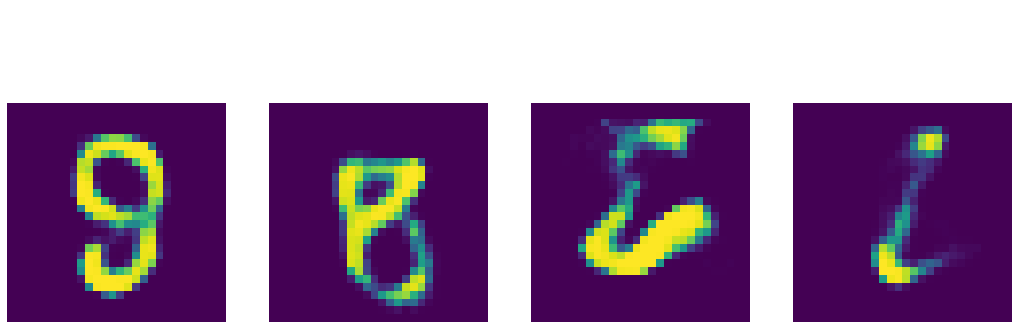

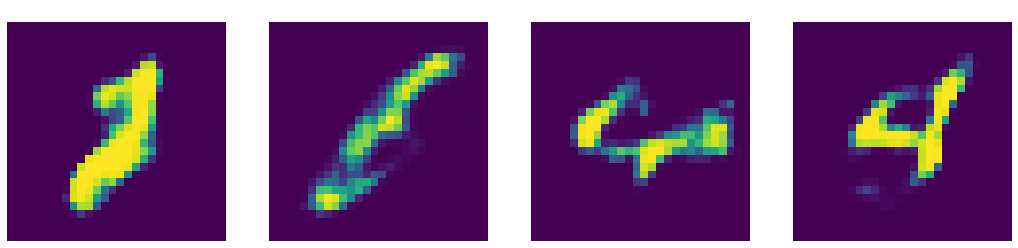

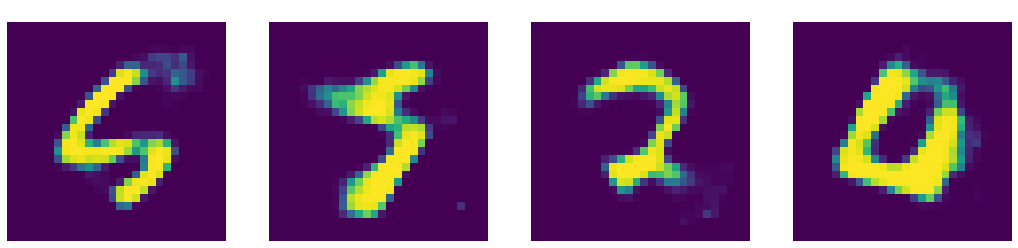

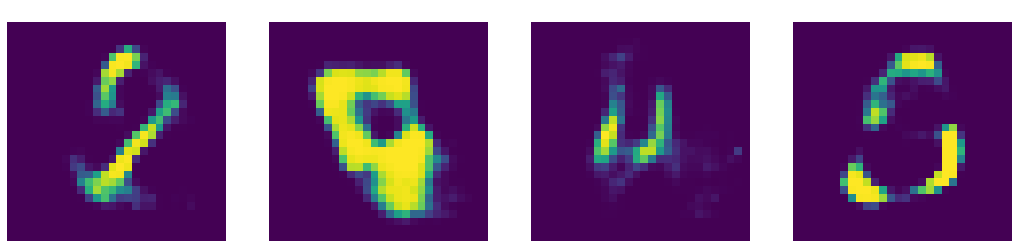

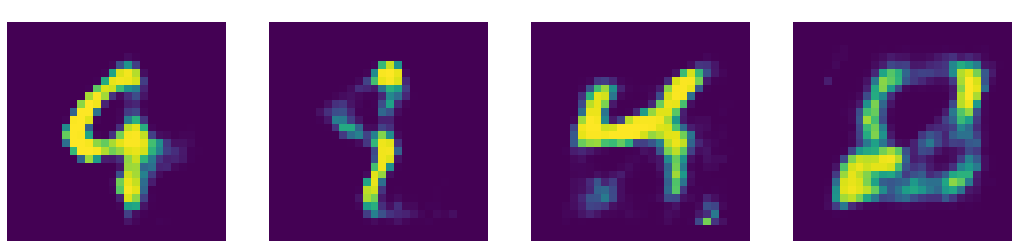

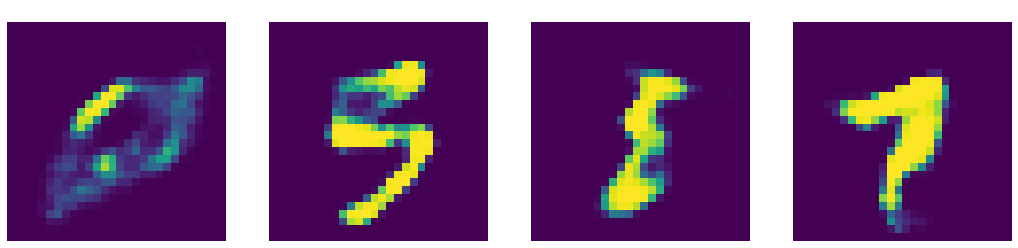

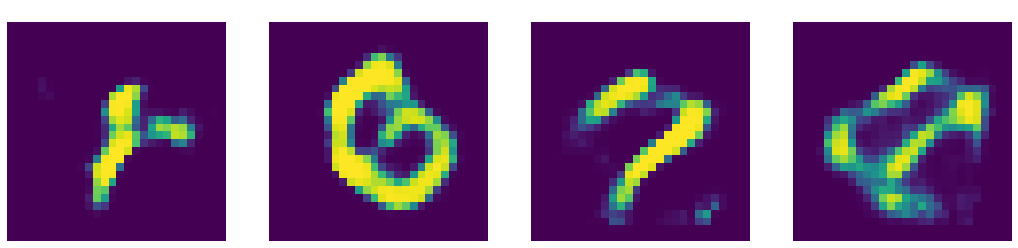

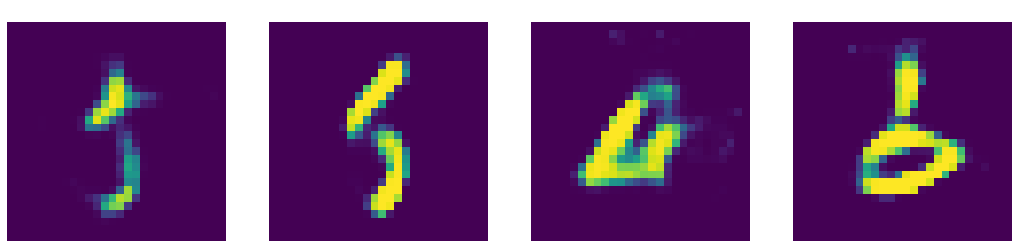

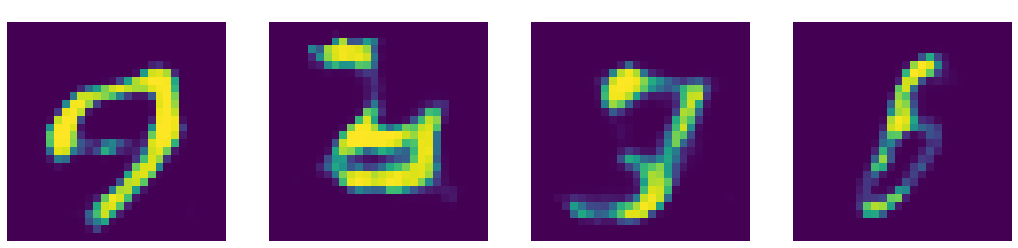

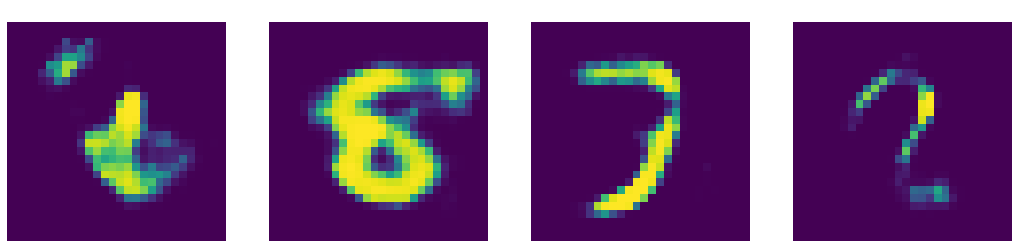

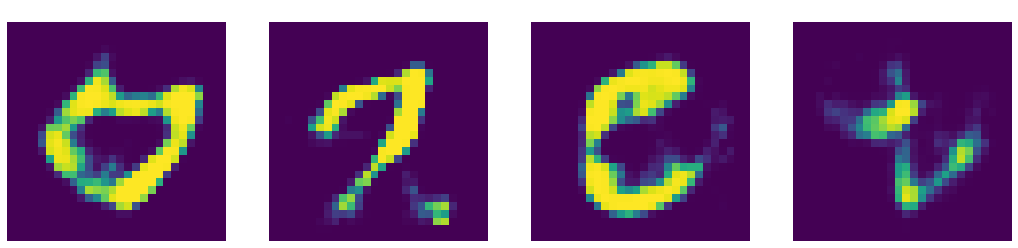

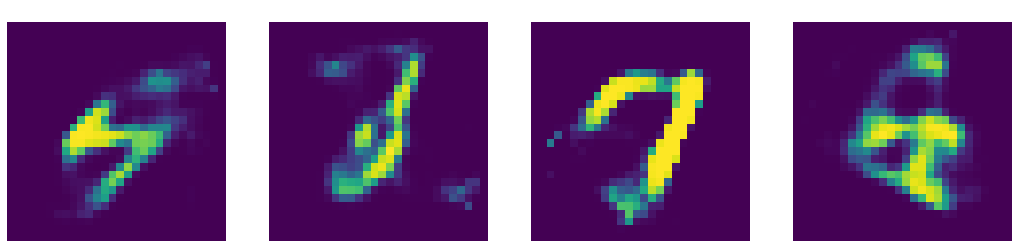

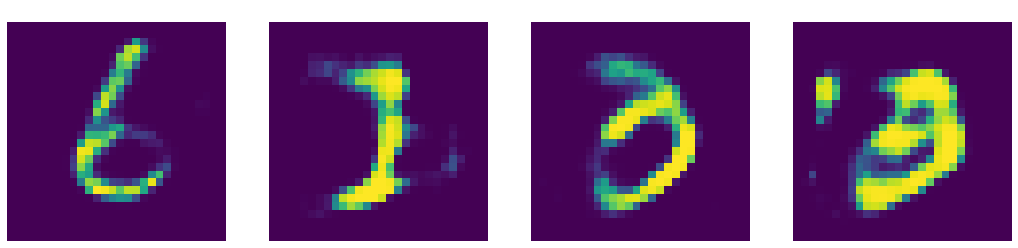

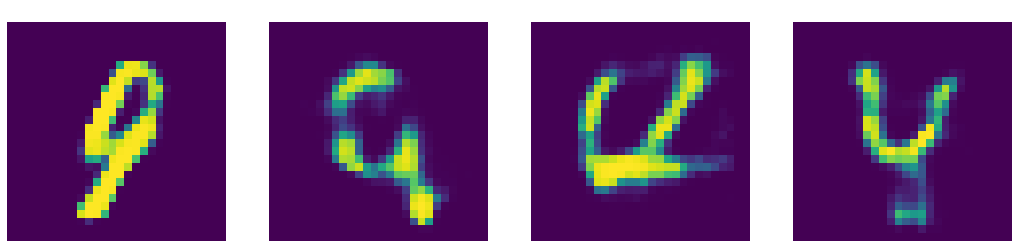

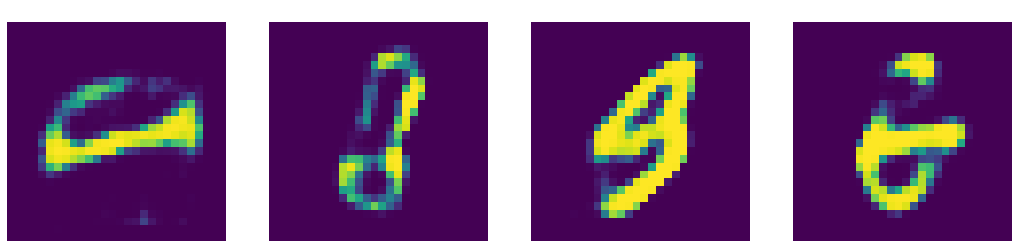

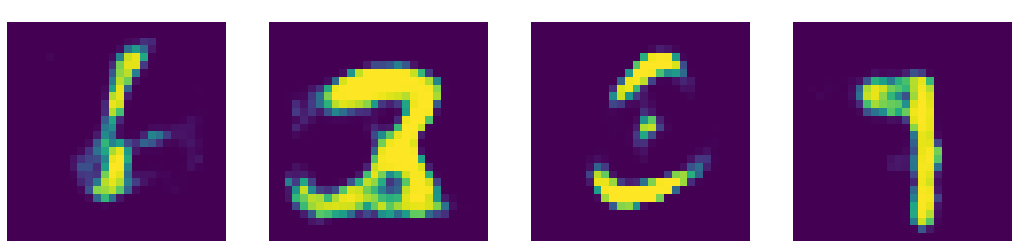

In [ ]:
# Generate 64 samples from the trained model and plot them.
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - Trained Model', 64 // 4, count=True)

# 3. Model Analysis

## 3.1. Interpolation - Start and End

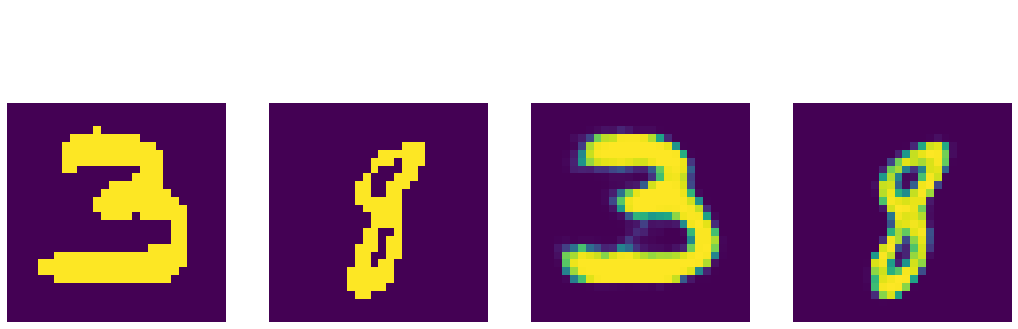

In [ ]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed
A, B = 12, 26
sample = model.decoder(torch.stack((codes['μ'][epoch-1][A].data, codes['μ'][epoch-1][B].data), 0))
display_images(None, torch.stack(((
    codes['x'][epoch-1][A].data.view(-1),
    codes['x'][epoch-1][B].data.view(-1),
    sample.data[0],
    sample.data[1]
))), 'Interpolation Start and End')

## 3.2. Interpolation in N

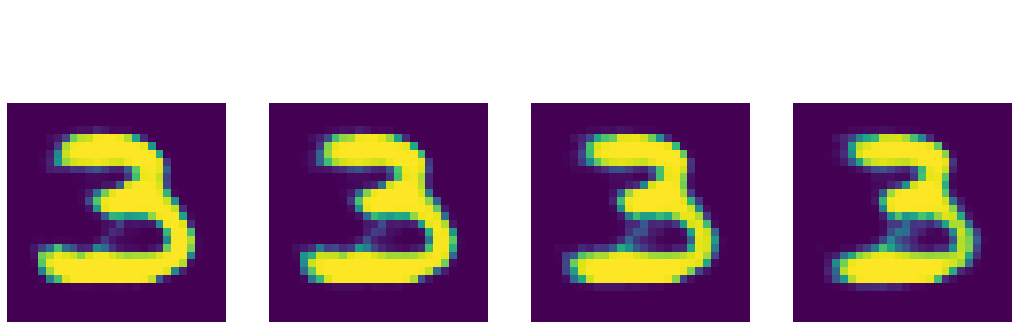

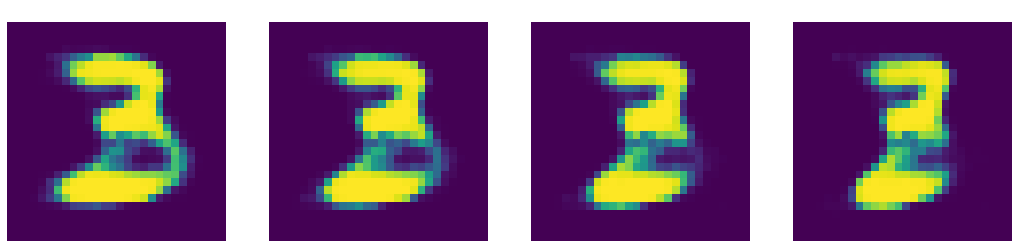

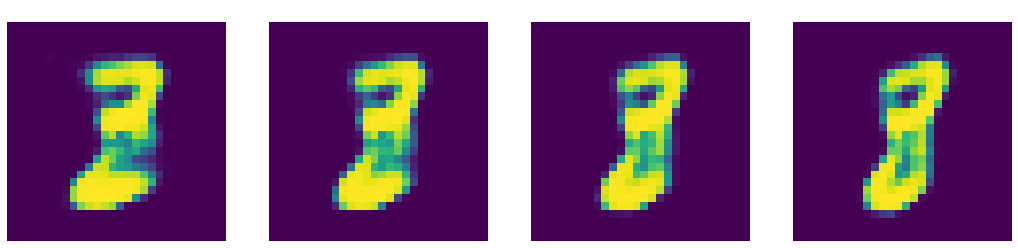

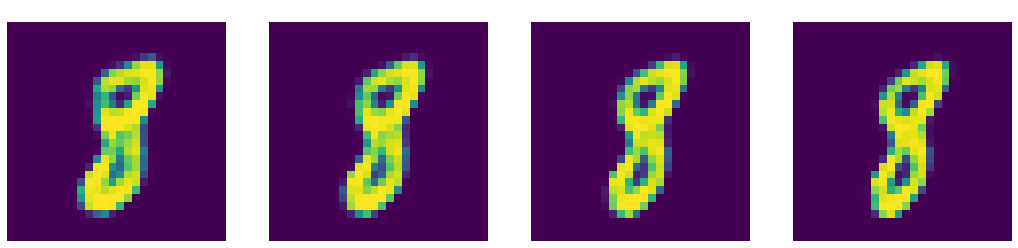

In [ ]:
# Perform a linear interpolation between 2 inputs A and B in the latent space and send it through the decoder
# by walking in the latent space we get to reconstruct things that look legit in the input space
N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * codes['μ'][epoch-1][B].data + (1 - i / (N - 1) ) * codes['μ'][epoch-1][A].data
sample = model.decoder(code)
display_images(None, sample, 'Interpolation in N steps', N // 4, count=True)

## 3.3. Plot latent space

Showing a representation of the embeddings (of the means) of the test set where we perform a dimensionality reduction which shows how the encoder clusters all the means in different regions in the latent space.

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 24, 49)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

In [ ]:
set_default(figsize=(20, 6))

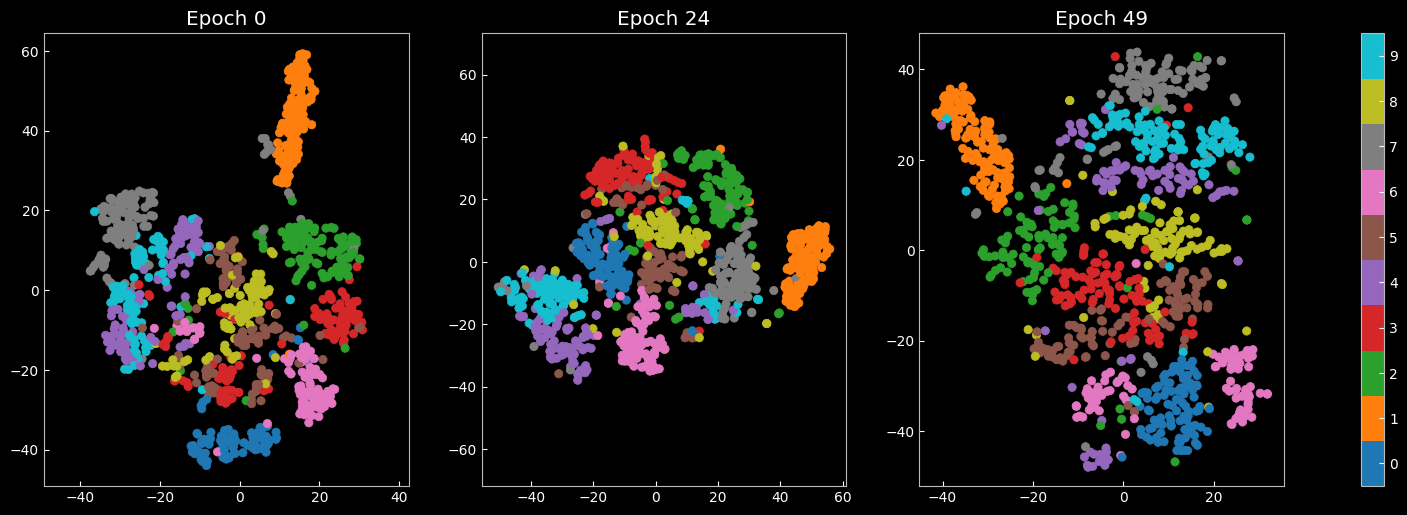

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

# 4. Semi-Supervised VAE (M1)

## 4.1. Prepare dataset

### 4.1.1. Creating a subset of the dataset

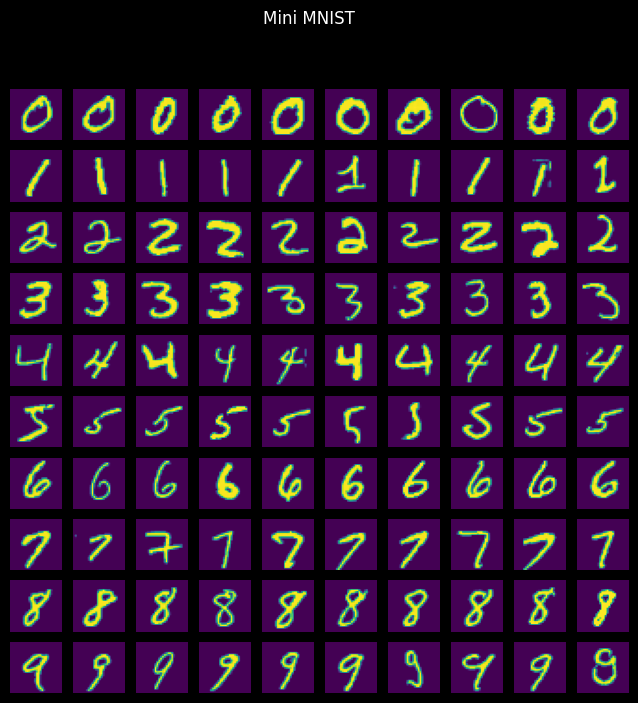

In [ ]:
# extract 100 labeled datapoints (10 from each class)
data_list, targets_list = [], []

# take 10 of each class
for class_ in range(10):
  idx = bin_ds_train.targets == class_
  data_list.append(bin_ds_train.data[idx][0:10, :, :])
  targets_list.append(bin_ds_train.targets[idx][0:10])

# convert the lists to tensors
mini_ds_data = torch.cat(data_list, 0)
mini_ds_targets = torch.cat(targets_list, 0)

# make sure the type is correct
mini_ds_data = mini_ds_data.to(dtype=torch.float32)
mini_ds_targets = mini_ds_targets.to(dtype=torch.long)

# create a dataset and a loader
mini_ds = TensorDataset(mini_ds_data, mini_ds_targets)
mini_dl = DataLoader(mini_ds, batch_size=100, drop_last=False, shuffle=False, num_workers=1, pin_memory=cuda)

# plot all the dataset
plot_samples_grid(mini_dl, n_rows=10, n_cols=10, title='Mini MNIST')

### 4.1.2. Process mini dataset to convert images to latent vectors

In [ ]:
with torch.no_grad():
  model.eval()
  for x, _ in mini_dl:
    x = x.to(device)
    # encode
    mu, logvar = model.encode(x)
    # reparameterize (there will be 1 batch only)
    z = model.reparameterise(mu, logvar)

# make sure the type is correct
mini_ds_latent_vectors = z.to(dtype=torch.float32)

In [ ]:
# prepare the new mini dataset for training classifiers
latent_mini_ds = TensorDataset(mini_ds_latent_vectors, mini_ds_targets)
latent_mini_dl = DataLoader(latent_mini_ds, batch_size=4, drop_last=False, shuffle=True, num_workers=1, pin_memory=cuda)

## 4.2. Classifiers

In [ ]:
# to collect info about the performance of the various classifiers
clf_stats = {}

### 4.2.1. Linear Classifier

In [ ]:
# a simple linear model
class LinearClassifier(nn.Module):

  def __init__(self):
      super(LinearClassifier, self).__init__()
      
      self.layer_1 = nn.Linear(in_features=latent_size, out_features=10, bias=True)

  def forward(self, x):
    x = x.view(-1, latent_size)
    logits = self.layer_1(x)
    return F.log_softmax(logits, dim=1)

linearClassifier = LinearClassifier()
print(linearClassifier)

LinearClassifier(
  (layer_1): Linear(in_features=20, out_features=10, bias=True)
)


In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(linearClassifier.parameters(), lr=0.001)

In [ ]:
epochs = 200
train_loss_vals, test_loss_vals, test_accuracies = [], [], []
for epoch in range(1, epochs+1): 
  # train on the mini dataset (the latent version)
  linearClassifier.train()
  train_loss = 0
  for x, y in latent_mini_dl:
    x = x.to(device) # the latent vector
    y = y.to(device) # the target label
    # forward
    y_hat = linearClassifier(x)
    loss = criterion(y_hat, y)
    train_loss += loss.item()
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(latent_mini_dl.dataset)
  train_loss_vals.append(train_loss)
  
  # evaluate over the whole test set
  with torch.no_grad():
    linearClassifier.eval()
    test_loss = 0
    correct = 0
    for x, y in bin_test_loader:
        x = x.to(device) # the image
        y = y.to(device) # the target label

        # we need to encode to latent vectors
        model.eval()
        mu, logvar = model.encode(x)
        z = model.reparameterise(mu, logvar)

        # forward
        y_hat = linearClassifier(z)
        test_loss += F.nll_loss(y_hat, y, reduction='sum').item()  # sum up batch loss
        pred = y_hat.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(y.view_as(pred)).sum().item()

  accuracy = 100. * correct / len(bin_test_loader.dataset)
  test_loss /= len(bin_test_loader.dataset)
  test_loss_vals.append(test_loss)
  test_accuracies.append(accuracy)

  if epoch % 10 == 0:
    print(f'===== Epoch {epoch} =====')
    print(f'Average train loss: {train_loss:.4f}')
    print(f'Average test loss: {test_loss:.4f}, Accuracy: {accuracy:.0f}%')

# save avg accuracy to clf_stats
clf_stats['m1_linear_model'] = max(test_accuracies)

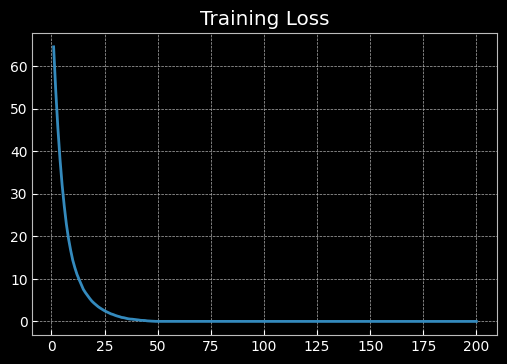

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss_vals)

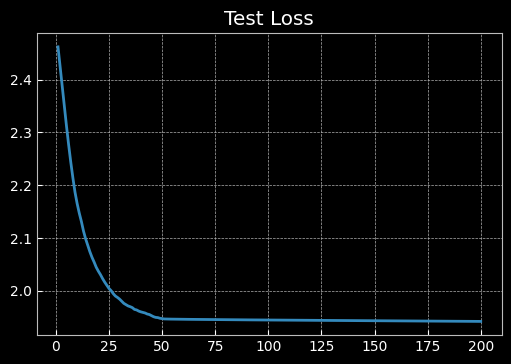

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Loss')
plt.plot(range(1, epochs+1), test_loss_vals)

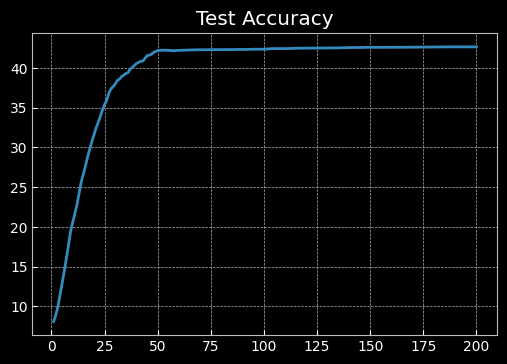

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Accuracy')
plt.plot(range(1, epochs+1), test_accuracies)

### 4.2.2. NN Classifier

In [ ]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

n_neighbors = 15

knn_x = mini_ds_latent_vectors.detach().clone()
knn_y = mini_ds_targets.detach().clone()

# grid search
#List Hyperparameters to tune
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,30))
# p=[1,2]
#convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Making model
# knn_clf = neighbors.KNeighborsClassifier()
# clf = GridSearchCV(knn_clf, hyperparameters, cv=10)
# best_model = clf.fit(knn_x, knn_y)

# create an instance of Neighbours Classifier and fit the data.
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
knn_clf.fit(knn_x, knn_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')

In [ ]:
accuracies = []
with torch.no_grad():
  for x, y in bin_test_loader:
    x = x.to(device) # the image
    y = y.to(device) # the target label
    
    # we need to encode to latent vectors
    model.eval()
    mu, logvar = model.encode(x)
    z = model.reparameterise(mu, logvar)

    # accuracy on this batch 
    accuracy = knn_clf.score(z, y)
    accuracies.append(accuracy)

print(f'KNN Classifier: average accuracy:{100. * np.average(accuracies):.4f}%')

# save avg accuracy to clf_stats
clf_stats['m1_knn'] = 100. * np.average(accuracies)

KNN Classifier: average accuracy:9.0039%


### 4.2.3. SVM

In [ ]:
# training a linear SVM classifier 
from sklearn.svm import SVC 

svm_x = mini_ds_latent_vectors.detach().clone()
svm_y = mini_ds_targets.detach().clone()

svm_clf = SVC(kernel = 'linear', C = 1).fit(svm_x, svm_y)

In [ ]:
accuracies = []
with torch.no_grad():
  for x, y in bin_test_loader:
    x = x.to(device) # the image
    y = y.to(device) # the target label
    
    # we need to encode to latent vectors
    model.eval()
    mu, logvar = model.encode(x)
    z = model.reparameterise(mu, logvar)

    # accuracy on this batch 
    accuracy = svm_clf.score(z, y)
    accuracies.append(accuracy)

print(f'SVM Classifier: average accuracy:{100. * np.average(accuracies):.4f}')

# save avg accuracy to clf_stats
clf_stats['m1_svm'] = 100. * np.average(accuracies)

SVM Classifier: average accuracy:9.7363


### 4.2.4. Decision Tree

In [ ]:
# training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier

tree_x = mini_ds_latent_vectors.detach().clone()
tree_y = mini_ds_targets.detach().clone()

dtree_clf = DecisionTreeClassifier(max_depth = 2).fit(tree_x, tree_y)

In [ ]:
accuracies = []
with torch.no_grad():
  for x, y in bin_test_loader:
    x = x.to(device) # the image
    y = y.to(device) # the target label
    
    # we need to encode to latent vectors
    model.eval()
    mu, logvar = model.encode(x)
    z = model.reparameterise(mu, logvar)

    # accuracy on this batch
    accuracy = dtree_clf.score(z, y)
    accuracies.append(accuracy)

print(f'DTree Classifier: average accuracy:{100. * np.average(accuracies):.4f}')

# save avg accuracy to clf_stats
clf_stats['m1_dtree'] = 100. * np.average(accuracies)

DTree Classifier: average accuracy:10.0000


## 4.3. Baseline

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = nn.Linear(784, 32)
    self.l2 = nn.Linear(32, 16)
    self.l3 = nn.Linear(16, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = self.l3(x)
    return F.log_softmax(x, dim=1)

baseline_model = Net().to(device)
print(baseline_model)

Net(
  (l1): Linear(in_features=784, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=16, bias=True)
  (l3): Linear(in_features=16, out_features=10, bias=True)
)


In [ ]:
criterion = nn.NLLLoss() # the negative log-likelihood loss.
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.5)

In [ ]:
# use a different loader to adjust loading settings
bl_mini_dl = DataLoader(mini_ds, batch_size=5, drop_last=False, shuffle=True, num_workers=1, pin_memory=cuda)

In [ ]:
epochs = 200
train_loss_vals, test_loss_vals, test_accuracies = [], [], []
for epoch in range(1, epochs+1):
  # train using only the 100 labeled data points
  baseline_model.train()
  train_loss = 0
  for x, y in bl_mini_dl:
    x = x.to(device)
    y = y.to(device)
    # forward
    y_hat = baseline_model(x)
    loss = criterion(y_hat, y)
    train_loss += loss.item()
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(bl_mini_dl.dataset)
  train_loss_vals.append(train_loss)

  # evaluate over the whole test set
  with torch.no_grad():
    baseline_model.eval()
    test_loss = 0
    correct = 0
    for x, y in bin_test_loader:
      x = x.to(device)
      y = y.to(device)

      # forward
      y_hat = baseline_model(x)
      test_loss += F.nll_loss(y_hat, y, reduction='sum').item()  # sum up batch loss
      pred = y_hat.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(y.view_as(pred)).sum().item()
  
  accuracy = 100. * correct / len(bin_test_loader.dataset)
  test_loss /= len(bin_test_loader.dataset)
  test_loss_vals.append(test_loss)
  test_accuracies.append(accuracy)

  if epoch % 10 == 0:
    print(f'===== Epoch {epoch} =====')
    print(f'Average train loss: {train_loss:.4f}')
    print(f'Average test loss: {test_loss:.4f}, Accuracy: {accuracy:.0f}%')

# save avg accuracy to clf_stats
clf_stats['baseline_model'] = max(test_accuracies)

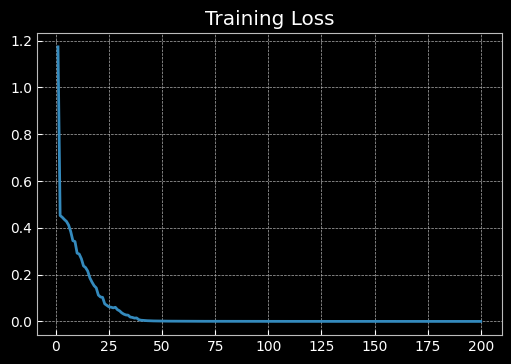

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss_vals)

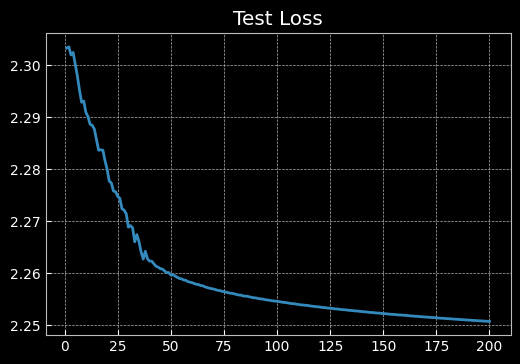

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Loss')
plt.plot(range(1, epochs+1), test_loss_vals)

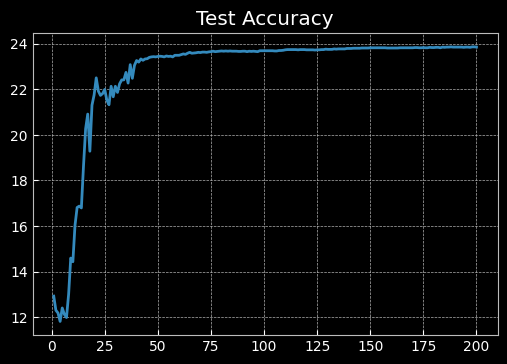

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Accuracy')
plt.plot(range(1, epochs+1), test_accuracies)

## 4.4. Overall comparison

In [ ]:
clf_stats

{'baseline_model': 23.86,
 'm1_dtree': 10.0,
 'm1_knn': 9.00390625,
 'm1_linear_model': 42.67,
 'm1_svm': 9.736328125}

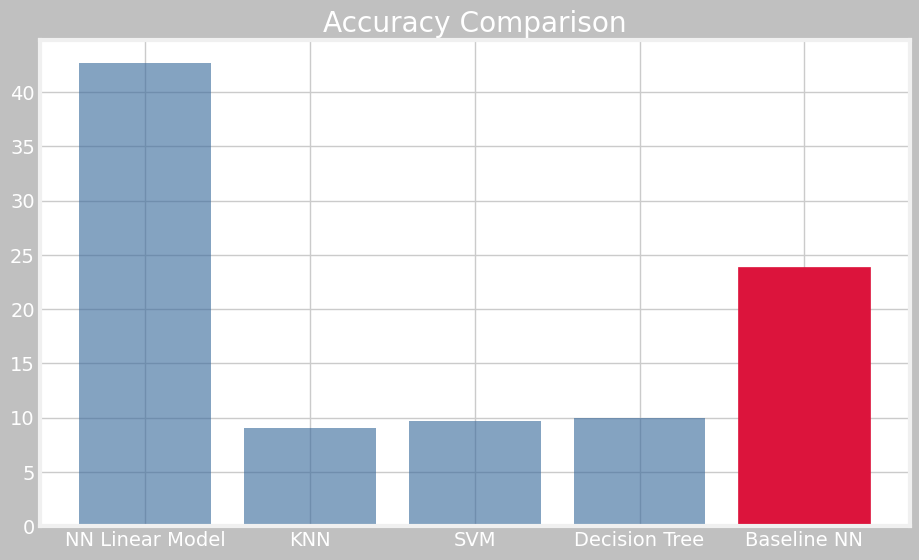

In [ ]:
names = list(clf_stats.keys())
values = list(clf_stats.values())

plt.style.use(['fivethirtyeight'])
plt.rc('axes', facecolor='w')
plt.rc('figure', facecolor='silver')
plt.rc('figure', figsize=(10, 6), dpi=100)

# set_default(figsize=(10, 6), dpi=100)
plt.title('Accuracy Comparison')
bg = plt.bar(['NN Linear Model', 'KNN', 'SVM', 'Decision Tree', 'Baseline NN'], values, color=(0.2, 0.4, 0.6, 0.6))
# bg[1].set_color('crimson')
# bg[0].set_color('teal')
# bg[1].set_color('teal')
# bg[2].set_color('teal')
# bg[3].set_color('teal')
bg[4].set_color('crimson')
# bg.show()

# 5. Semi-Supervised VAE (M2)

## 5.1. Implement VAE Model

In [ ]:
# hyper params
latent_size = 20

In [ ]:
class M2VAE(nn.Module):
    def __init__(self):
      super(M2VAE, self).__init__()

      # input (x) -> class label (y)
      self.encoder1 = nn.Sequential(
          nn.Linear(784, latent_size ** 2),
          nn.ReLU(),
          nn.Linear(latent_size ** 2, 10),
          nn.Softmax(dim=1) # used softmax to better align with the one-hot encoding for labeled data
      )

      # input (x) + class label (y) -> latent vector (z)
      self.encoder2 = nn.Sequential(
          nn.Linear(784 + 10, latent_size ** 2),
          nn.ReLU(),
          nn.Linear(latent_size ** 2, latent_size * 2)
      )

      # latent vector (z) + class label (y) -> reconstructed input (x)
      self.decoder1 = nn.Sequential(
          nn.Linear(latent_size + 10, latent_size ** 2),
          nn.ReLU(),
          nn.Linear(latent_size ** 2, 784),
          nn.Sigmoid(),
      )

    def reparameterise(self, mu, logvar):
      if self.training:
          std = logvar.mul(0.5).exp_()
          eps = std.data.new(std.size()).normal_() # normal dist.
          return eps.mul(std).add_(mu)
      else:
          return mu

    def encode(self, x, y=None):
      if y is None: 
        # unlabeled data or evaluating
        y_hat = self.encoder1(x.view(-1, 784)) # q(y|x) -> (batch_size, 10)
        # compute the encoder + dec
      else:
        # labeled data (one-hot encode to align with the previous case) -> (batch_size, 10)
        y_hat = torch.nn.functional.one_hot(y).to(device)

      # input (batch_size, 794)
      mu_logvar = self.encoder2(torch.cat((x.view(-1, 784), y_hat), dim=1)).view(-1, 2, latent_size) # q(z|y,x)
      mu = mu_logvar[:, 0, :]
      logvar = mu_logvar[:, 1, :]

      return mu, logvar, y_hat

    def decode(self, z, y):
      return self.decoder1(torch.cat((z, y), dim=1))

    def forward(self, x, y):
        mu, logvar, y_hat = self.encode(x, y)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z, y_hat)
        return x_hat, mu, logvar, y_hat

    def sample(self, z, labels):
      y = labels.to(device)
      z = z.to(device)
      # z = torch.randn((n_samples, latent_size)).to(device)
      # print(y.size(), z.size())
      return self.decode(z, y)

m2model = M2VAE().to(device)

In [ ]:
# Setting the optimiser
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    m2model.parameters(),
    lr=learning_rate,
)

In [ ]:
def loss_function(x_hat, x, mu, logvar):
    # reconstruction loss
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    # KL divergence loss
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

## 5.2. Setting up the training

In [ ]:
epochs = 100
train_loss_vals, test_loss_vals, test_accuracies = [], [], []
training_samples_limit = 100
for epoch in range(1, epochs+1):
  m2model.train()
  train_loss = 0
  training_samples_count = 0

  for x, y in bin_train_loader:
    x = x.to(device)
    # we need to only consider the first 100 having labels (note: there is shuffeling here!)
    if training_samples_count < training_samples_limit:
      y = y.to(device)
      training_samples_count += 1
    else:
      y = None # no label
    # forward
    x_hat, mu, logvar, y_hat = m2model(x, y)
    loss = loss_function(x_hat, x, mu, logvar)
    train_loss += loss.item()
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(bin_train_loader.dataset)
  train_loss_vals.append(train_loss)

  # evaluate over the whole test set
  lc_cel = nn.CrossEntropyLoss()
  with torch.no_grad():
    m2model.eval()
    test_loss = 0
    correct = 0
    for x, y in bin_test_loader:
      x = x.to(device)
      y = y.to(device)

      # forward
      x_hat, mu, logvar, y_hat = m2model(x, None)
      pred = y_hat.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      test_loss += lc_cel(y_hat, y).item()  # sum up batch loss
      correct += pred.eq(y.view_as(pred)).sum().item()
  
  accuracy = 100. * correct / len(bin_test_loader.dataset)
  test_loss /= len(bin_test_loader.dataset)
  test_loss_vals.append(test_loss)
  test_accuracies.append(accuracy)

  if epoch % 10 == 0:
    print(f'===== Epoch {epoch} =====')
    print(f'Average train loss: {train_loss:.4f}')
    print(f'Average test loss: {test_loss:.4f}, Accuracy: {accuracy:.0f}%')

In [ ]:
# save the state dict of the model
torch.save(m2model.state_dict(), 'm2model.pt')

In [ ]:
# loading a saved module
m2model = M2VAE().to(device)
m2model.load_state_dict(torch.load('m2model.pt'))

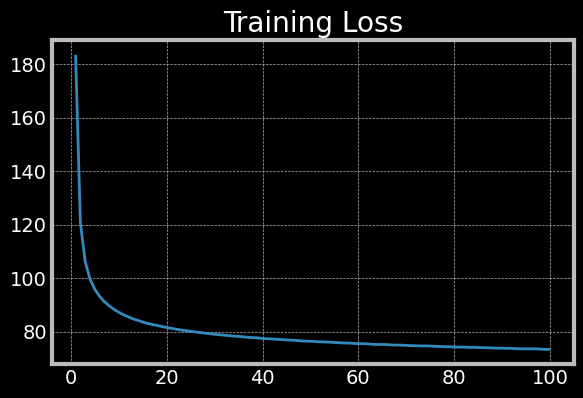

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss_vals)

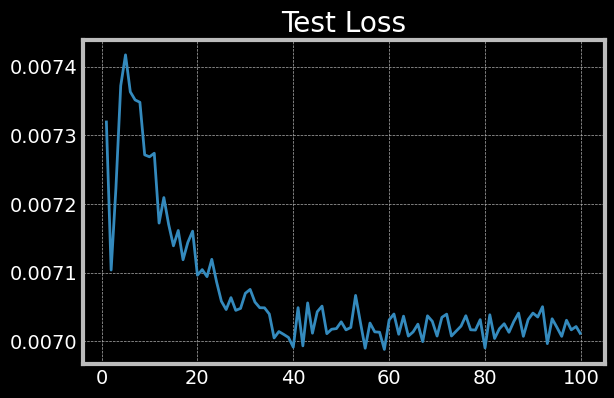

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Loss')
plt.plot(range(1, epochs+1), test_loss_vals)

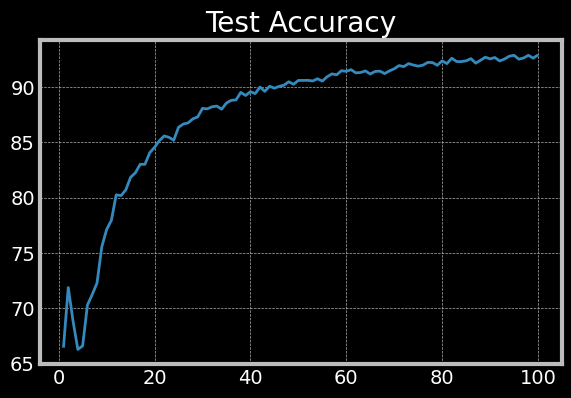

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Accuracy')
plt.plot(range(1, epochs+1), test_accuracies)

## 5.3. Analyze separation between style and class label

In [ ]:
# prepare one-hot encoded vectors of five
one_hot_five = torch.LongTensor([0,0,0,0,0,1,0,0,0,0])
one_hot_fives = one_hot_five.repeat(10, 1)

# sample latent vectors from gaussian distribution
sampled_z_latents = torch.randn((10, 20))

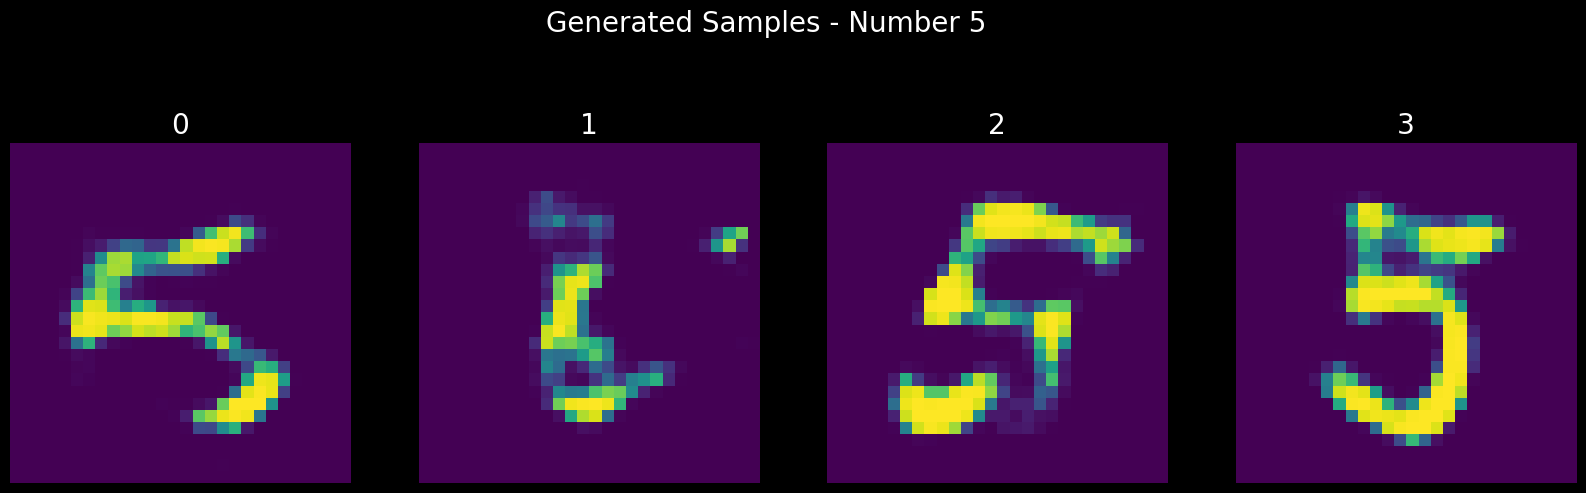

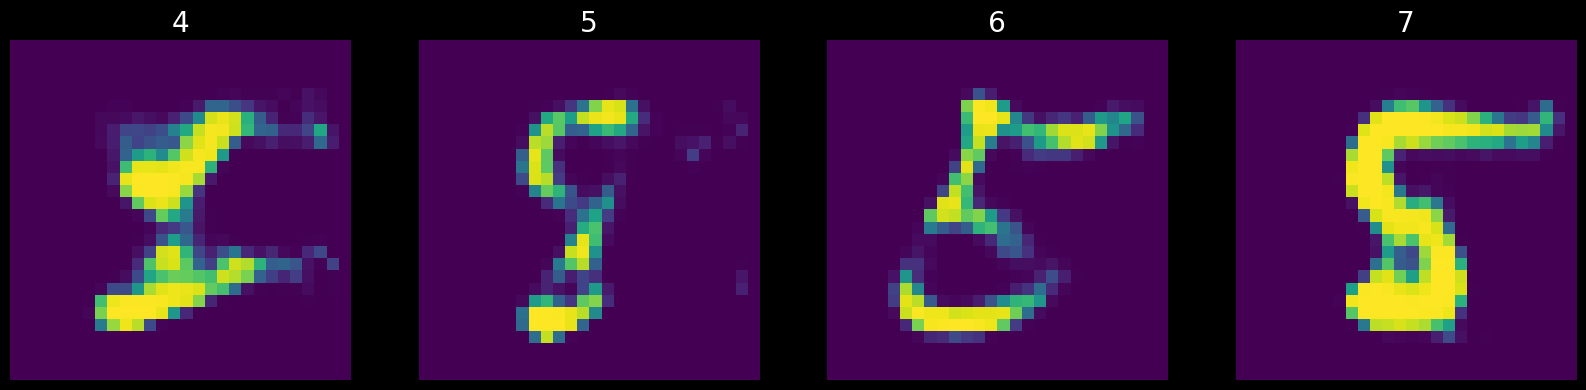

In [ ]:
set_default(figsize=(10, 6), dpi=100)

plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')

samples = m2model.sample(sampled_z_latents, one_hot_fives)
display_images(None, samples, 'Generated Samples - Number 5', 10 // 4, count=True)

In [ ]:
# prepare one-hot encoded vectors of three
one_hot_three = torch.LongTensor([0,0,0,1,0,0,0,0,0,0])
one_hot_threes = one_hot_three.repeat(10, 1)

# sample latent vectors from gaussian distribution
sampled_z_latents = torch.randn((10, 20))

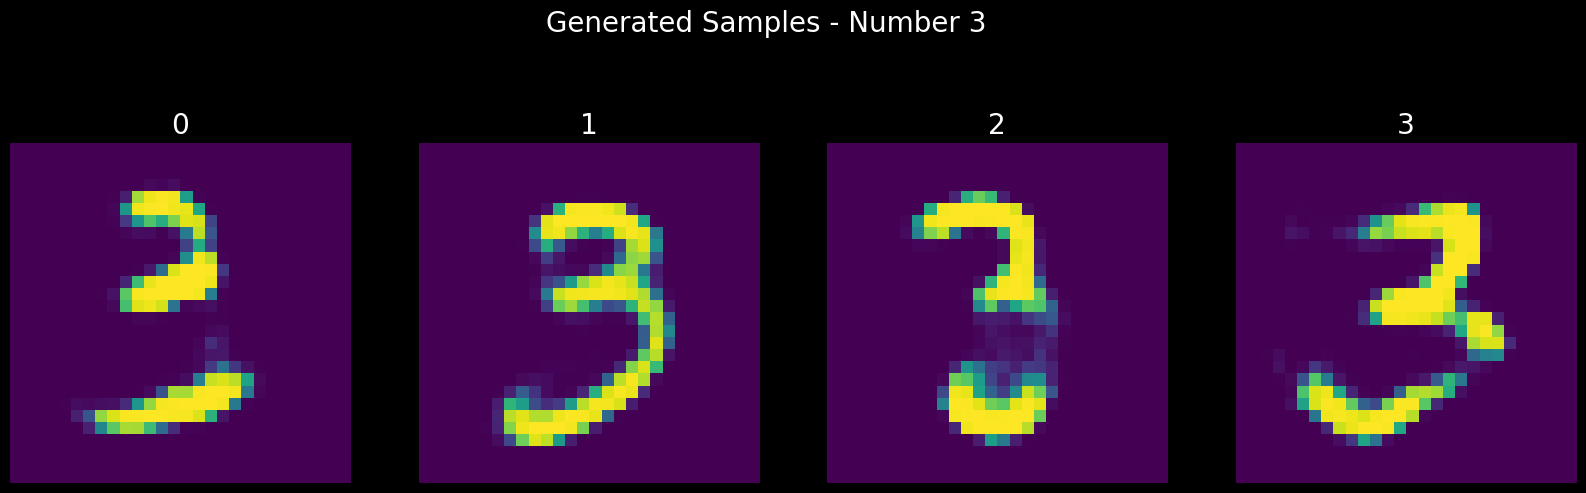

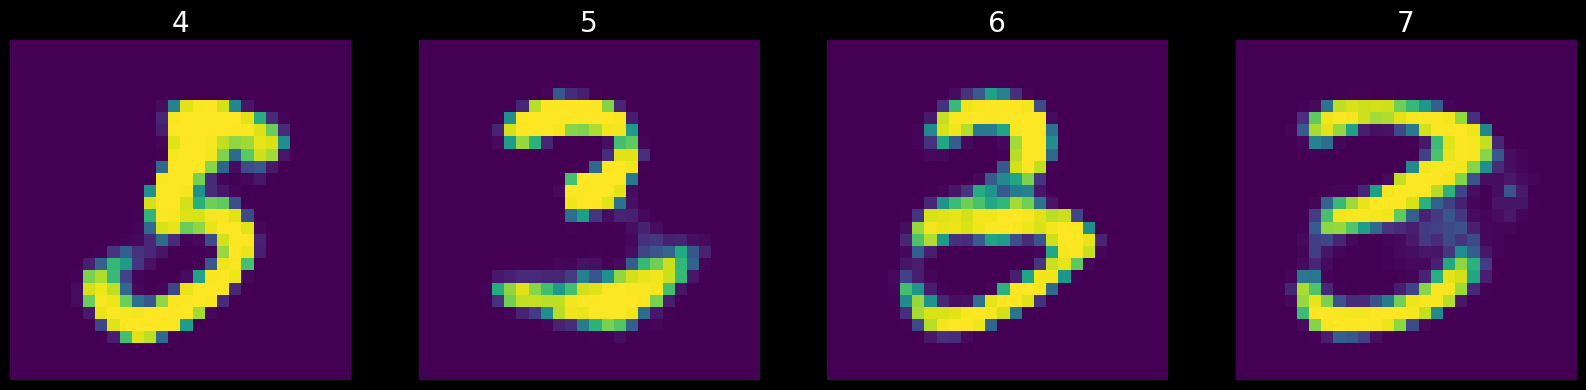

In [ ]:
set_default(figsize=(10, 6), dpi=100)

plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')

samples = m2model.sample(sampled_z_latents, one_hot_threes)
display_images(None, samples, 'Generated Samples - Number 3', 10 // 4, count=True)

In [ ]:
# prepare one-hot encoded vectors of seven
one_hot_seven = torch.LongTensor([0,0,0,0,0,0,0,1,0,0])
one_hot_sevens = one_hot_seven.repeat(10, 1)

# sample latent vectors from gaussian distribution
sampled_z_latents = torch.randn((10, 20))

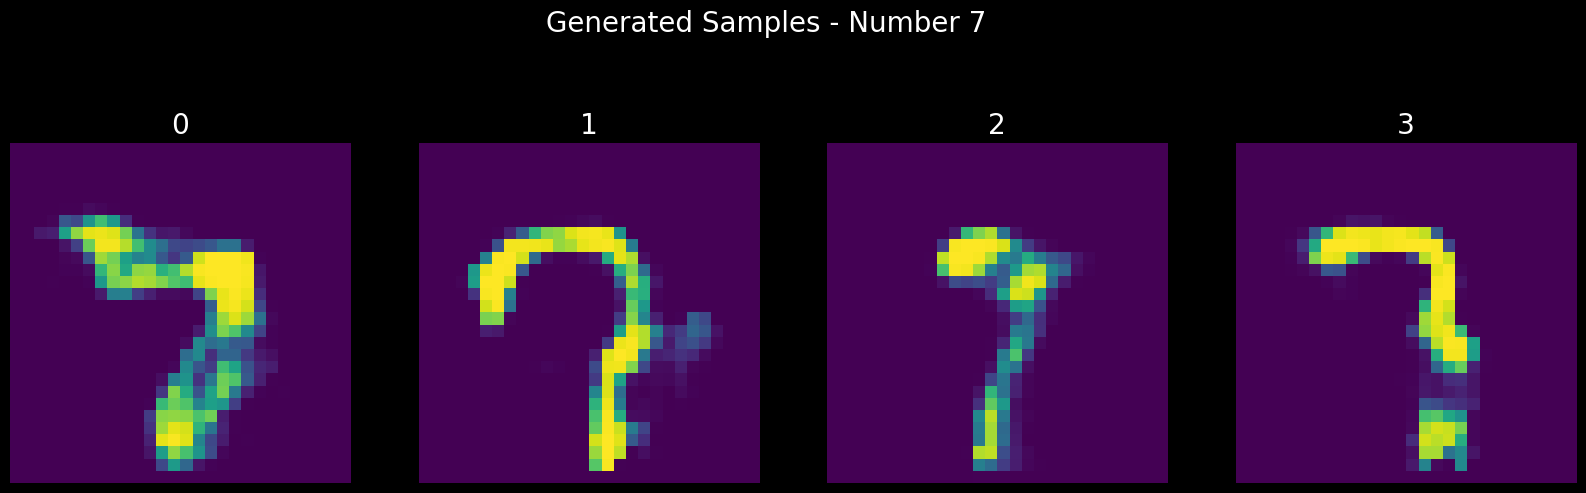

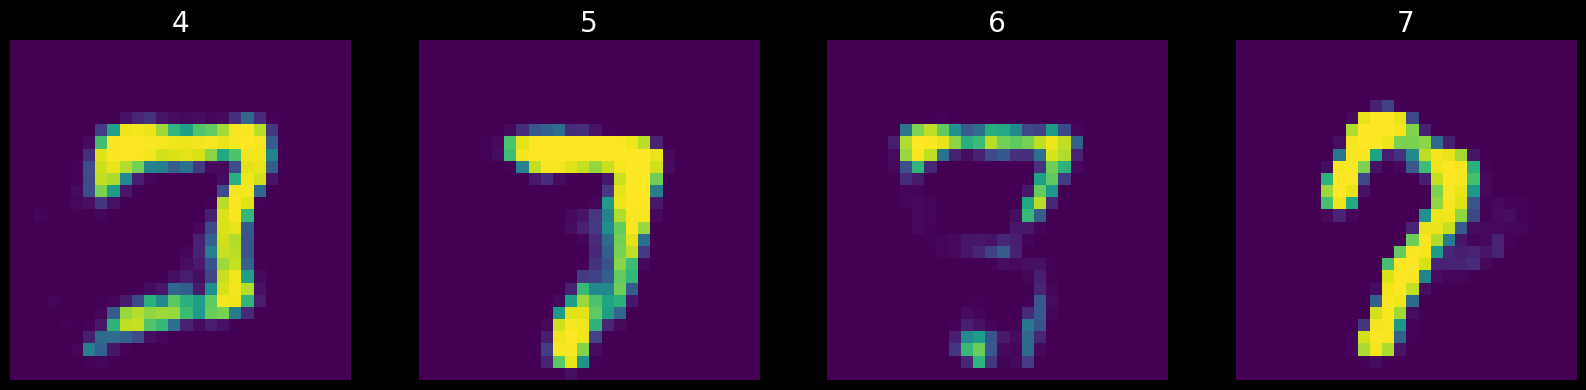

In [ ]:
set_default(figsize=(10, 6), dpi=100)

plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')

samples = m2model.sample(sampled_z_latents, one_hot_sevens)
display_images(None, samples, 'Generated Samples - Number 7', 10 // 4, count=True)

In [ ]:
# prepare one-hot encoded vectors
one_hot_one = torch.LongTensor([1,0,0,0,0,0,0,0,0,0])
one_hot_two = torch.LongTensor([0,1,0,0,0,0,0,0,0,0])
one_hot_three = torch.LongTensor([0,0,1,0,0,0,0,0,0,0])
one_hot_four = torch.LongTensor([0,0,0,1,0,0,0,0,0,0])
one_hot_five = torch.LongTensor([0,0,0,0,1,0,0,0,0,0])
one_hot_six = torch.LongTensor([0,0,0,0,0,1,0,0,0,0])
one_hot_seven = torch.LongTensor([0,0,0,0,0,0,1,0,0,0])
one_hot_eight = torch.LongTensor([0,0,0,0,0,0,0,1,0,0])
one_hot_nine = torch.LongTensor([0,0,0,0,0,0,0,0,1,0])
one_hot_ten = torch.LongTensor([0,0,0,0,0,0,0,0,0,1])

class_labels = torch.cat((one_hot_one, 
                          one_hot_two, 
                          one_hot_three, 
                          one_hot_four,
                          one_hot_five,
                          one_hot_six,
                          one_hot_seven,
                          one_hot_eight,
                          one_hot_nine,
                          one_hot_ten)).view(-1, 10)

# sample one latent vector from gaussian distribution
sampled_z_latent = torch.randn((1, 20))
sampled_z_latents = sampled_z_latent.repeat(10, 1)

# print(sampled_z_latents.size())
# print(class_labels.size())
# print(class_labels)
# print(sampled_z_latents)

In [ ]:
set_default(figsize=(10, 6), dpi=100)

plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')

samples = m2model.sample(sampled_z_latents, class_labels)
display_images(None, samples, 'Generated Samples', 10 // 2, count=True)